# 分类

原书用mnist数据集, 这里改用fashion mnist. 两者数据量, 图片大小均相同, 区别在于mnist的手写数字过于简单, fashion mnist中的图片换成了若干服饰.

## sklearn实现

In [1]:
import mnist_reader

In [3]:
# 数据要事先下载好, 放在../data/fashion目录
X_train, y_train = mnist_reader.load_mnist('../data/fashion', kind='train') # 6w张训练图片
X_test, y_test = mnist_reader.load_mnist('../data/fashion', kind='t10k')    # 1w张测试图片

In [4]:
X_train.shape

(60000, 784)

labels中数字和类型的对应关系为:

In [7]:
labels = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle',
}

### 二分类

和书中的例子一样, 将训练集分为 label5 和non-label5 两部分

In [8]:
y_train_5 = (y_train == 5)

In [9]:
y_test_5 = (y_test == 5)

Stochastic Gradient Descent (SGD) 名称中的随机是指, 每次只随机取一个样本计算梯度

In [10]:
from sklearn.linear_model import SGDClassifier

In [29]:
sgd_clf = SGDClassifier(tol=0.001, random_state=42) # 指定seed是为了复现测试

In [30]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

### 度量

一般机器学习中, 使用的交叉验证有这么几个特点:

- 交叉验证是把训练集再划分成两部分, 一部分训练, 另一部分测试; 而原来的测试集是不会用到的.一般只在最后验证泛化能力时,才让估计器接触测试集
- 默认交叉验证使用 KFold 或 StratifiedKFold 划分训练集, k默认取3. 即将数据集分为3组, 每次选两组用于训练, 一组用于测试,重复3次.
  可以通过设置**cv=k**来修改k值



#### 准确度(Accuracy)


In [21]:
from sklearn.model_selection import cross_val_score

In [31]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.97795, 0.97625, 0.97875])

#### 混淆矩阵(Confusion Matrix)

混淆矩阵中, $M_{ij}$ 代表将类i识别为类j的数量 

In [32]:
from sklearn.model_selection import cross_val_predict

In [37]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1) 

注意这里交叉验证进行了3轮, 有可能出现对于同一个样本, 每轮预测结果不同的情况. 没查到具体的说明, 猜测最终的预测值应该是按照多数服从少数原则确定的

In [44]:
from sklearn.metrics import confusion_matrix

In [45]:
confusion_matrix(y_train_5, y_train_pred)

array([[53685,   315],
       [ 1026,  4974]], dtype=int64)

#### 精度(Precision)和召回率(Recall)

Precision也叫 TPR(True Positive Rate)指, 识别为正例的样本中, 真正例的比例

$$\text{precision} = \frac{\text{TP}}{\text{TP + FP}}$$



Recall 指所有正例中, 正例被正确识别出来的比例
$$\text{recall} = \frac{\text{TP}}{\text{TP + FN}}$$

precision 和 recall 之间是跷跷板关系, 无法同时达到最优, 得根据需求进行取舍.

In [46]:
from sklearn.metrics import precision_score, recall_score

In [47]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.9404424276800908, 0.829)

指定cross_val_predict的method参数为 **decision_function** , 返回的结果不再是预测值, 而是所谓的decision score. 如果该值大于估计器的阈值, 样本将被分类为正例, 否则为负例.

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1, method='decision_function') 

根据decision scores 可以画所谓的 precision-recall 曲线

In [53]:
from sklearn.metrics import precision_recall_curve

In [72]:
import numpy as np

In [65]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='Set2') # 稍微美化下

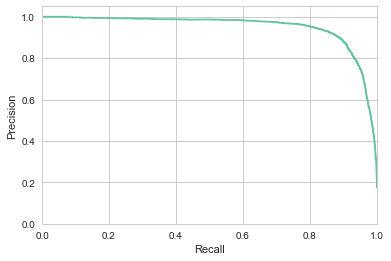

In [73]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0,1,0,1.05])
plt.show()

#### ROC(Receiver Operating Characteristic) Curve

ROC画的是TPR和FPR之间的关系

In [75]:
from sklearn.metrics import roc_curve

In [76]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

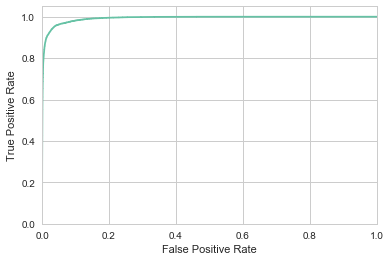

In [77]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis([0,1,0,1.05])
plt.show()

### 多分类

有些算法可以直接进行多分类. 至于只能二分类的算法, 可以通过使用多个二分类器来完成多分类. 
用二分类进行多分类的方式有两种(一对剩余所有OvA, 或者一对一OvO). 前者使用的分类器数量少, 但存在类别不平衡,从而影响分类效果. 后者需要更多的二分类器, 但每个分类器训练样本少, 单个分类器训练速度更快, 而且相对精度更高一点.

常见的算法中, 基本上用OvA更合适, 除了SVM(它用OvO, 因为算法只适合小样本,多特征的场景). 比如上面的SGDClassifier, 进行多分类就用的OvA

In [ ]:
sgd_clf.fit(X_train, y_train)